# Expanding the slow SSM in Kolmogorov flow

The vorticity equation is 

$$
\frac{\partial \omega }{\partial t} = \nu \Delta \omega - (u\cdot \nabla)\omega + F
$$

The laminar solution is 

$$
\omega_0 = \frac{1}{4\nu}\cos(4 y) 
$$

with 
$$
\frac{\partial \omega_0}{\partial t} = 0
$$




### Implementation of the RHS of the vorticity equation in Fourier space

### Define the parameter independent terms

In [2]:
import matplotlib.pyplot as plt

In [3]:
def gvars(n1, n2, L1, L2):
    X = np.linspace(-L1/2, L1/2 - L1/n1, n1)
    Y = np.linspace(-L2/2, L2/2 - L2/n2, n2)

    x, y = np.meshgrid(X, Y, indexing='ij')

    kx1 = np.concatenate((torch.arange(0, n1//2), 
                     torch.arange(-n1//2, 0))) * (2*np.pi/L1)
    ky1 = np.concatenate((torch.arange(0, n2//2), 
                     torch.arange(-n2//2, 0))) * (2*np.pi/L2)

    kx, ky = np.meshgrid(kx1, ky1, indexing = 'ij')

    return x, y, kx, ky

In [4]:

def dissipation_torch(w):
    return torch.mean(w**2, axis = 0)

In [5]:
def dealiasing_indices(kx, ky, n1, n2):
    """
    2/3 dealiasing in torch
    """
    # Chandler & Kerswell use this
    ksq = kx**2 + ky**2
    k0 = (n1/3)**2
    k_cutoff = (ksq <= k0)  # This will give you a tensor of 1s and 0s, where condition holds

    return k_cutoff

In [6]:
import torch
import numpy as np

def dealiase_torch(ff, kx, ky, n1, n2):
    """
    2/3 dealiasing in torch
    """

    # if real take to Fourier domain
    RorC = torch.is_complex(ff)
    if not RorC:
        ff = torch.fft.fftn(ff)

    # Chandler & Kerswell use this
    ksq = kx**2 + ky**2
    k0 = (n1/3)**2
    k_cutoff = (ksq <= k0)  # This will give you a tensor of 1s and 0s, where condition holds

    ff = k_cutoff * ff

    # take back to physical domain
    if not RorC:
        ff = torch.fft.ifftn(ff).real  # 'symmetric' means we're expecting a real output

    return ff

In [7]:
L1 = 2*np.pi
L2 = 2*np.pi 
n1 = 24
n2 = 24

x, y, kx, ky = gvars(n1,n2,L1,L2)
x = torch.tensor(x, dtype = torch.float64, device="cpu").requires_grad_(True)
y = torch.tensor(y, dtype = torch.float64,device="cpu").requires_grad_(True)
kx = torch.tensor(kx, dtype = torch.float64, device="cpu").requires_grad_(True)
ky = torch.tensor(ky, dtype = torch.float64, device="cpu").requires_grad_(True)


In [8]:

def rhs_torch_fourier_tf(w_flat, kx, ky, nu, x, y, n1, n2):
    fw = w_flat.reshape((n1, n2))
    ksq = kx**2 + ky**2

    #fw = torch.fft.fftn(w)

    # compute \nabla\omega
    fwx = 1j*kx*fw; wx = torch.fft.ifftn(fwx).real
    fwy = 1j*ky*fw; wy = torch.fft.ifftn(fwy).real
    ksq2 = ksq.clone().detach()
    ksq2[0,0] = 1e17 # to circumwent in-place modification of w
    
    
    fpsi = fw / ksq2

    fu1 =  1j*ky*fpsi; u1 = torch.fft.ifftn(fu1).real
    fu2 = -1j*kx*fpsi; u2 = torch.fft.ifftn(fu2).real
    # add NL term in physical domain
    rhs_w =  -(u1*wx + u2*wy)
    # add forcing
    rhs_w2 = (rhs_w - 4*torch.cos(4*y))

    # add dissipation term in Fourier domain
    frhsw = torch.fft.fftn(rhs_w2)
    frhsw2 = frhsw - nu*ksq*fw

    # dealiase
    frhsw = dealiase_torch(frhsw, kx, ky, n1, n2)

    # take back to physical domain
    #rhs_w = torch.fft.ifftn(frhsw2).real

    return frhsw2.ravel()

## Export the coefficients in a loop

In [11]:
from scipy.integrate import solve_ivp

In [12]:
from tqdm import tqdm
from scipy.io import savemat

In [13]:
import hdf5storage


In [15]:
def newton_method(F, u0, tol=1e-6, max_iter=1000):
    """Simple Newton's method."""
    u = u0.clone().detach().requires_grad_(True)
    sol = {}
    sol['u0'] = u0
    for _ in range(max_iter):
        #print(_)
        f_val = F(u)
        jacobian = torch.autograd.functional.jacobian(F, u) # derivative wrt u
        du = -torch.linalg.lstsq(jacobian, f_val).solution

        u  = u +  du.squeeze()
        #print(torch.linalg.norm(F(u)))

        if torch.linalg.norm(du) < tol:
            sol['x'] = u
            break
    sol['x'] = u

    if torch.linalg.norm(F(u)) < tol:
        sol['success'] = 1
    return sol

## Recover results

In [28]:
import numpy as np
from scipy.io import loadmat
import sympy as sy
p1= sy.symbols('p_1')
var = np.array([p1]).reshape(1,1)
import taylor_to_pade

In [29]:
from taylor_to_pade.matlab_integration import *
from taylor_to_pade.approximant import TaylorSeries, PadeApproximant

In [30]:
def approximate_mfd(xi, order, omega_list):
    omega = xi**0 * omega_list[0]
    for o in range(1,order):
        omega += xi**o * omega_list[o]
    return omega



In [31]:
def extract_w0_new(matt):
    mat_array = []
    matt = matt['W_0'][0]
    order = len(matt)
    for i in range(order):
        dictt = {}
        if matt['coeffs'][i].shape[0]>0:
            dictt['coeffs'] = np.array(matt['coeffs'][i])
            dictt['ind'] = np.array(matt['ind'][i], dtype= int)
        else:
            dictt['coeffs'] = []
            dictt['ind'] = []
        mat_array.append(dictt)
    return mat_array


In [32]:
def extract_r0_new(matt):
    mat_array = []
    matt = matt['R_0'][0]
    order = len(matt)
    for i in range(order):
        dictt = {}
        if matt['coeffs'][i].shape[0]>0:
            dictt['coeffs'] = np.array(matt['coeffs'][i])
            dictt['ind'] = np.array(matt['ind'][i], dtype= int)
        else:
            dictt['coeffs'] = []
            dictt['ind'] = []
        mat_array.append(dictt)
    return mat_array


In [35]:
Re_selected = 11.

/opt/anaconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


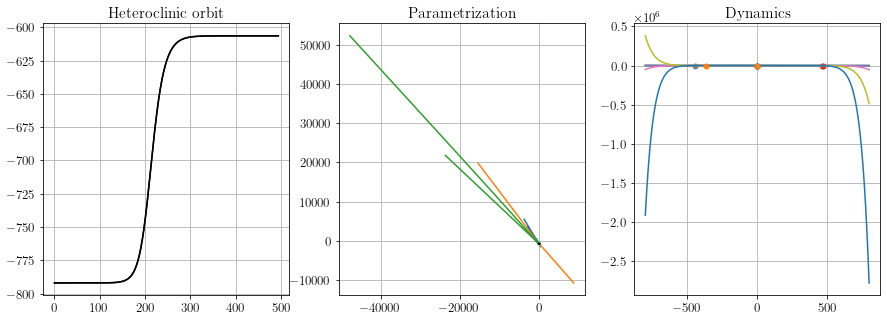

In [34]:
Re = Re_selected
filename = '/Users/bkaszas/data_for_matlab_coeffs_nontriv_fp_kolmogorov/unstable_mfd_fourier_data_sept21_re_%s_' %(Re)
filename = filename.replace('.', '__')
filename += '.mat'
mat = loadmat(filename)
mat['W_0'] = mat['W0']
mat['R_0'] = mat['R0']
del mat['R0']
del mat['W0']
matt = mat['W_0'][0]
W0 = extract_w0_new(mat) # get parametrization
R0 = extract_r0_new(mat) # get reduced dyn
# assemble symbolic expression for reduced dyn
reduced_dyn = p1*0
R0[0]['coeffs'] = R0[0]['coeffs'].item().toarray()
coeffs_numpy = [0]
for r in R0:
    ind_ = r['ind'][0][0]
    coeff = r['coeffs'][0][0].real
    reduced_dyn += coeff * p1**ind_
    coeffs_numpy.append(coeff)
# assemble coefficients for parametrization.
# need to recover the laminar solution as well and the simulated trajectories: 
filename = '/Users/bkaszas/data_for_matlab_coeffs_nontriv_fp_kolmogorov/data_sept21_re_%s_' %(Re)
filename = filename.replace('.', '__')
filename += '.mat'
dat = hdf5storage.read(filename = filename)
w_0_ft = dat['w0']
plus = dat['plus']
minus = dat['minus']

coeffs_param = [w_0_ft]
for w in W0:
    coeff = w['coeffs']
    coeffs_param.append(np.squeeze(coeff))

xis_numpy = np.linspace(-500, 500, 3000).reshape(-1,1)
fig = plt.figure(figsize = (15, 5))
ax = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
nu = 1/Re
w_0 = -Re * torch.cos(4 * y)/4
w_0_ft = torch.fft.fftn(w_0).ravel()
w_0_ft.retain_grad()
rh = lambda x : rhs_torch_fourier_tf(x, kx, ky, nu, x, y, n1, n2)
# find unstable eigenvalue and eigenvector
jac = torch.autograd.functional.jacobian(rh, w_0_ft)
s, v = torch.linalg.eig(jac)
ss = s.numpy()
lamb = np.max(ss.real)
eig_index = np.argmax(ss.real)
w_1 = v[:,eig_index].real

time_length = 20 / lamb
teval = np.linspace(0, time_length, 5000)


ax.plot(teval, minus[20,:], c= 'black')
ax.plot(teval, plus[20,:],  c= 'black')
ax.set_title('Heteroclinic orbit')
for o in range(3, 16):
    mfd = approximate_mfd(xis_numpy, o, coeffs_param).T
    ax2.plot(mfd[28,:], mfd[20,:])


ax2.plot(minus[28,:], minus[20,:], c= 'black')
ax2.plot(plus[28,:], plus[20,:],  c= 'black')
ax2.set_title('Parametrization')
xis_numpy = np.linspace(-800, 800, 3000).reshape(-1,1)

for o in range(10, 16):
    red_dyn = approximate_mfd(xis_numpy, o, coeffs_numpy).T
    ax3.plot(np.squeeze(xis_numpy), np.squeeze(red_dyn))
    fixedpoint = np.roots(coeffs_numpy[:o][::-1])
    real_fixedpoints = fixedpoint[fixedpoint.imag == 0]
    filt = np.logical_and(real_fixedpoints<800, real_fixedpoints>-800)
    fp =real_fixedpoints[filt]
    ax3.plot(fp, fp*0, '.', markersize = 10)


ax3.set_title('Dynamics')
# ax.plot(minus[28,:], minus[20,:], c= 'black')
# ax.plot(plus[28,:], plus[20,:],  c= 'black')
ax.grid()
ax2.grid()
ax3.grid()
    
    
    #plt.plot(p_28(xis_numpy) / q_28(xis_numpy), p_20(xis_numpy) / q_20(xis_numpy), c='violet')


## Select the wave numbers to visualize

In [36]:
indices = np.arange(0, 576, 1)
where_lam = np.abs(plus[:,0])>1

In [37]:
indices[where_lam]

array([ 4, 20])

Same with the nontriv fp:

In [38]:
indices = np.arange(0, 576, 1)
where_nontriv = np.abs(plus[:,-1])>1

In [43]:
ind1, ind2, ind3 = 20, 28, 44

In [44]:
from scipy.interpolate import pade

In [45]:
p, q = pade(coeffs_numpy, 7, 7)
#p_512, q_512 = pade(coeffs_512, 3, 3)

/opt/anaconda3/lib/python3.8/site-packages/scipy/interpolate/_pade.py:63: LinAlgWarning: Ill-conditioned matrix (rcond=4.73436e-32): result may not be accurate.
  pq = linalg.solve(C, an)


In [47]:
orders = [3, 5, 11, 16]

In [48]:
colors = plt.cm.coolwarm(np.linspace(0,1,len(orders)))

### 

In [49]:
orders

[3, 5, 11, 16]

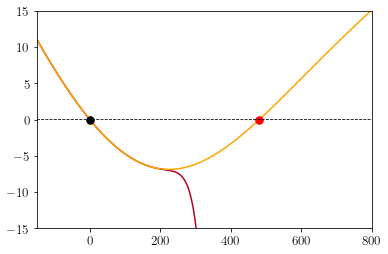

In [97]:
fig = plt.figure()
ax3 = fig.add_subplot(111)

xis_numpy = np.linspace(-900, 1500, 3000).reshape(-1,1)

for i,o in enumerate(orders):
    red_dyn = approximate_mfd(xis_numpy, o, coeffs_numpy).T
    if o == 16:
        ax3.plot(1*np.squeeze(xis_numpy), 1 *np.squeeze(red_dyn), '-', c=colors[i])
    fixedpoint = np.roots(coeffs_numpy[:o][::-1])
    real_fixedpoints = fixedpoint[fixedpoint.imag == 0]
    filt = np.logical_and(real_fixedpoints<800, real_fixedpoints>-800)
    fp =real_fixedpoints[filt]
    #ax3.plot(prefac*fp, fp*0, '.', markersize = 10)
#ax3.plot(1* np.squeeze(xis_numpy) , 1 * p_3(np.squeeze(xis_numpy)) / q_3(np.squeeze(xis_numpy)),  '--', c= 'Orange')
ax3.plot(1* np.squeeze(xis_numpy) , 1 * p_5(np.squeeze(xis_numpy)) / q_5(np.squeeze(xis_numpy)),  '-', c= 'Orange')
ax3.plot(0,0,'.', c='black', markersize = 15.)
ax3.plot(xis_numpy[1725,0],0.,'.', c='red', markersize = 15.)
#ax3.plot(447.3447395, 0., '.')



# ax_cbar = fig.add_axes([0.58, 0.23, 0.22, 0.01])

# cb = mpl.colorbar.ColorbarBase(ax_cbar, values = orders, orientation='horizontal', 
#                                cmap=cmap)
# ax_cbar.set_title('Taylor order', fontsize = 12)
ax3.set_ylim(-15, 15)

ax3.set_xlim(-150, 800)
#ax3.grid()
ax3.plot(np.squeeze(xis_numpy), np.squeeze(xis_numpy)*0, '--', linewidth = 0.8, c='black')
#ax3.plot(reduced_plus[0,:], ddxi_plus)

#ax3.plot(reduced_minus[0,:], ddxi_minus)
plt.savefig('figs/to_manuscript_dynamics_fewer.pdf', bbox_inches='tight')

/var/folders/63/3f75hvg57sg3ft1y4q72fj8mrcdrwp/T/ipykernel_58689/1393043957.py:4: RuntimeWarning: overflow encountered in square
  omega += xi**o * omega_list[o]
/var/folders/63/3f75hvg57sg3ft1y4q72fj8mrcdrwp/T/ipykernel_58689/1393043957.py:4: RuntimeWarning: overflow encountered in power
  omega += xi**o * omega_list[o]
/var/folders/63/3f75hvg57sg3ft1y4q72fj8mrcdrwp/T/ipykernel_58689/1393043957.py:4: RuntimeWarning: invalid value encountered in add
  omega += xi**o * omega_list[o]


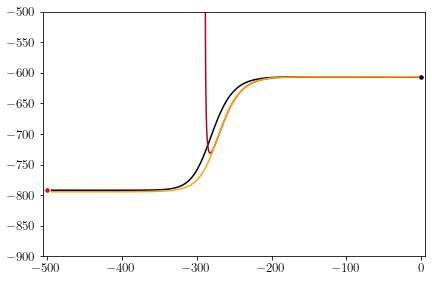

In [131]:
ff = plt.figure(figsize = (1.5*3*1.52, 1.5*3))
ax = ff.add_subplot(111)
ax.plot(-teval, minus[20,:][::-1], c= 'black')

for i,o in enumerate(orders):
    ## integrate reduced model backward:
    red_lam = lambda t,x: approximate_mfd(x, o, coeffs_numpy).T
    ic_nn = approximate_mfd(ic_xi, o, coeffs_param).T
    
    # forward_full = solve_ivp(ode_rhs, [0, time_length], ic_nn, t_eval=teval).y
    # backward_full = solve_ivp(ode_rhs, [0,-time_length], ic_nn, t_eval=-teval).y
    
    forward_red = solve_ivp(red_lam, [0, time_length], [ic_xi], t_eval=teval).y
    backward_red = solve_ivp(red_lam, [0,-time_length], [ic_xi], t_eval=-teval)
    
    forward_red_par = approximate_mfd(forward_red.T, o, coeffs_param).T
    backward_red_par = approximate_mfd(backward_red.y.T, o, coeffs_param).T
#    plt.plot(backward_red.t, backward_red.y[0,:], '-', c=colors[i])
    if o == 16:
        ax.plot(backward_red.t, backward_red_par[20,:], '-', c=colors[i])
    
rade_red = lambda t, x :  p_5(np.squeeze(x)) / q_5(np.squeeze(x))
backward_pade_red = solve_ivp(rade_red, [0,-time_length], [ic_xi], t_eval=-teval)
backward_red_pade_par = p_20_5(np.squeeze(backward_pade_red.y)) / q_20_5(np.squeeze(backward_pade_red.y))
ax.plot(-teval, backward_red_pade_par, '-', c='orange')
ax.plot(0, minus[20,-1], '.', c='black', markersize = 7)
ax.plot(-500, minus[20,0], '.', c='red', markersize = 7)

ax.set_ylim(-900, -500)
ax.set_xlim(-505, 5)
plt.savefig('figs/time_domain_integrate__fewer.pdf', bbox_inches='tight')
    #    plt.plot(teval, forward_full[20,:], mfd[44,:], c=colors[i])